In [1]:
import torch
import kornia
import matplotlib.pyplot as plt
import numpy as np
import cv2
plt.rcParams['figure.figsize'] = [12, 9]

In [2]:
# input - img (H,W,C)
# output - img (H,W,C)
def MySeamCarving(img, new_shape):
    
    # input - img (H,W,C)
    # output - energy (H,W)
    def calc_energy(img):
        # convert image to a normalized tensor of shape (B,C,H,W)
        img = torch.from_numpy(img.astype(np.float32)/255).permute(2,0,1).unsqueeze(0)
        gradient = kornia.filters.spatial_gradient(img).permute(2,0,1,3,4)
        Ix = gradient[0]
        Iy = gradient[1]
        energy = Ix.abs() + Iy.abs()    
        energy = torch.sum(energy.squeeze(0), (0))   
        return energy
    
    # input - energy (H,W)
    # output - img (H,W,C)
    def CarvingHelper(energy):
        M = energy.clone()
        
        # go through all the cells and create the M matrix which stores the minimum cumulative sum of energies (build M)
        for row in range(1, energy.shape[0]):
            for col in range(0, energy.shape[1]):
                if col == 0:
                    M[row, col] += torch.min(M[row - 1, col], M[row - 1, col + 1])
                elif col == energy.shape[1] - 1:
                    M[row, col] += torch.min(M[row - 1, col - 1], M[row - 1, col])
                else:
                    M[row, col] += torch.min(M[row - 1, col - 1:col + 2])
    
        # seam_mask stores 1 for the pixels that need to be removed
        seam_mask = torch.zeros_like(energy)
        col = torch.argmin(M[-1])
        
        # backtrack from last row to find the seam/pixels with least amount of cumulative energy
        for row in range(energy.shape[0] - 1, -1, -1):
            seam_mask[row, col] = 1
            if col == 0:
                col += torch.argmin(M[row - 1, col:col + 2])
            elif col == energy.shape[1] - 1:
                col += torch.argmin(M[row - 1, col - 1:col + 1]) - 1
            else:
                col += torch.argmin(M[row - 1, col - 1:col + 2]) - 1
        
        seam_mask = torch.stack([seam_mask, seam_mask, seam_mask], dim=2)        
        # every row value, but without the column values where seam_mask = 1
        final = img[seam_mask == 0].reshape((energy.shape[0], energy.shape[1] - 1, 3))
        return final

    # Remove vertical seams - horizontally stretched or cropped
    for _ in range(img.shape[1] - new_shape[1]):
        energy = calc_energy(img)
        img = CarvingHelper(energy)

    # Remove horizontal seams - vertically stretched or cropped
    for _ in range(img.shape[0] - new_shape[0]):
        img = img.transpose(1,0,2)
        energy = calc_energy(img)
        img = CarvingHelper(energy)
        img = img.transpose(1,0,2)


    return img

# BEFORE SEAM CARVING

(1151, 1728, 3)


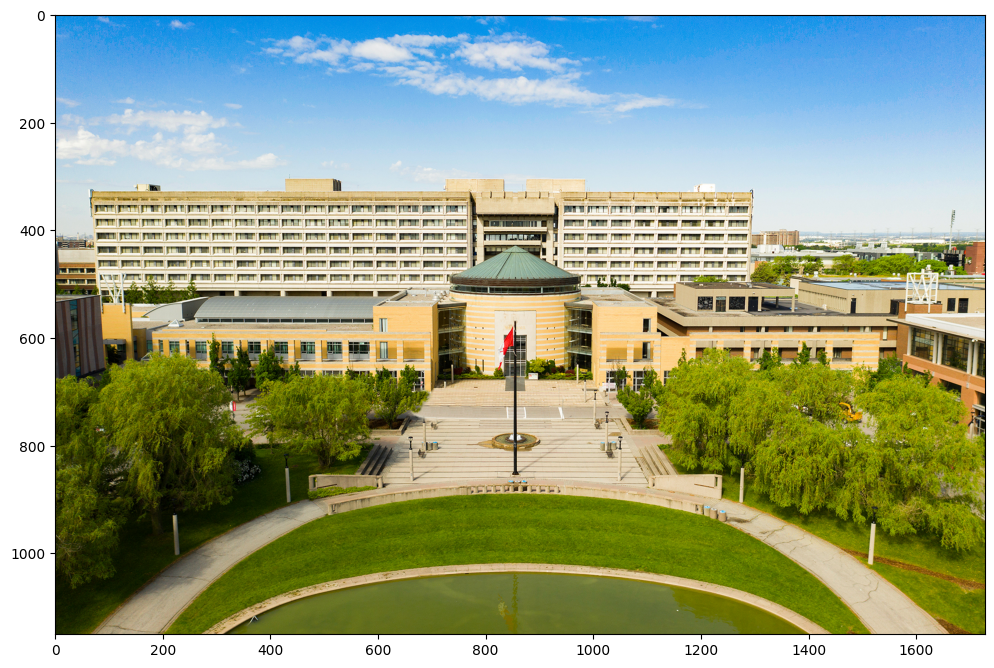

In [3]:
# shape (1151, 1728, 3)
img = plt.imread('York.jpg')
print(img.shape)
plt.imshow(img)

(1151, 1450, 3)


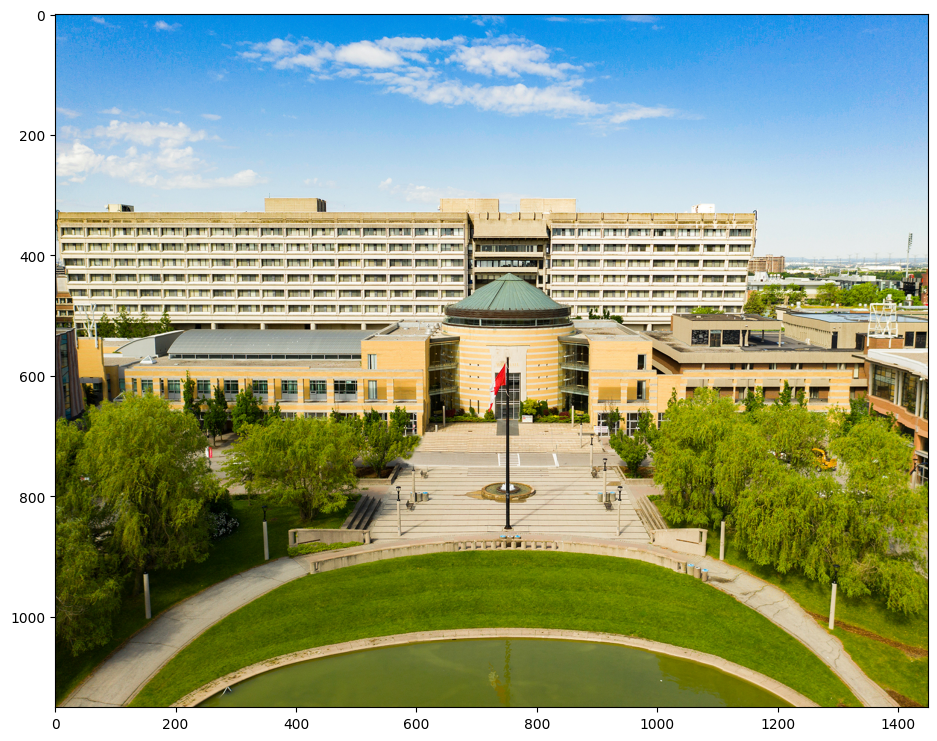

In [5]:
# carved to 1400 width because it was taking too long to get to 1200 and my laptop was getting hot, feel free to run it again with the desired shape
seam_carved_img1 = MySeamCarving(img, (1151, 1450))
print(seam_carved_img1.shape)
plt.imshow(seam_carved_img1)

In [6]:
seam_carved_img2 = MySeamCarving(img, (1000, 1728))
print(seam_carved_img2.shape)
plt.imshow(seam_carved_img2)

(1000, 1728, 3)
